In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
#import streamlit as st
#from bokeh.plotting import figure, show

%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')

# 1. Create dictionary that map characters into Morse Code:

Use reccomendations of the Radiocommunication sector of the International Telecomunication Union
* https://www.itu.int/dms_pubrec/itu-r/rec/m/R-REC-M.1677-1-200910-I!!PDF-E.pdf

Notes: 
   * '[' and ']' are not defined, 
   * ''' is difficul to define (but apostrophe is defined)

In [2]:
to_MC = {
    'A': '. | - | ',
    'B': '- | . | . | . | ',
    'C': '- | . | - | . | ',
    'D': '- | . | . | ',
    'E': '. | ',
    'F': '. | . | - | . | ',
    'G': '- | - | . | ',
    'H': '. | . | . | . | ',
    'I': '. | . | ',
    'J': '. | - | - | - | ',
    'K': '- | . | - | ',
    'L': '. | - | . | . | ',
    'M': '- | - | ',
    'N': '- | . | ',
    'O': '- | - | - | ',
    'P': '. | - | - | . | ',
    'Q': '- | - | . | - | ',
    'R': '. | - | . | ',
    'S': '. | . | . | ',
    'T': '- | ',
    'U': '. | . | - | ',
    'V': '. | . | . | - | ',
    'W': '. | - | - | ',
    'X': '- | . | . | - | ',
    'Y': '- | . | - | - | ',
    'Z': '- | - | . | . | ',
    '1': '. | - | - | - | - | ',
    '2': '. | . | - | - | - | ',
    '3': '. | . | . | - | - | ',
    '4': '. | . | . | . | - | ',
    '5': '. | . | . | . | . | ',
    '6': '- | . | . | . | . | ',
    '7': '- | - | . | . | . | ',
    '8': '- | - | - | . | . | ',
    '9': '- | - | - | - | . | ',
    '0': '- | - | - | - | - | ',
#    '\n': ' ',
    ' ': '/',
    '&': '. | - | . | . | . | ',
    '=': '- | . | . | . | - | ',
    '+': '. | - | . | - | . | ',
    '/': '- | . | . | - | . | ', 
    '(': '- | . | - | - | . | ', 
    '’': '. | − | − | − | − | . | ',
    '@': '. | - | - | . | - | . | ',
    ':': '- | - | - | . | . | . | ',
    ';': '- | . | - | . | - | . | ',
    '.': '. | - | . | - | . | - | ',
    ',': '- | - | . | . | - | - | ', 
    '?': '. | . | - | - | . | . | ', 
    '"': '. | - | . | . | - | . | ',
    '!': '- | . | - | . | - | - | ',
    '-': '- | . | . | . | . | - | ',
    ')': '- | . | - | - | . | - |',
    '%': '- | - | - | - | - | - | . | . | - | . | - | - | - | - | - | '} #0/0

# 1.2. Some rules:

https://www.itu.int/dms_pubrec/itu-r/rec/m/R-REC-M.1677-1-200910-I!!PDF-E.pdf

## 1.2.1 Spacing between signals:

1. A dash is equal to three dots (could be amplitude or duration).
2. The space between the signals forming the same letter is equal to one dot.
3. The space between two letters is equal to three dots.
4.The space between two words is equal to seven dots.

## 1.2.2 General transmission rules:

1. All correspondence between two stations shall begin with the call signal (of the station required) and the signal (- . -).

4. A transmission, once begun, may not be interrupted to give place to a communication of higher priority except in a case of absolute urgency.

5. Every telegram shall be terminated with a cross signal (. – . – .).

6. The end of the transmission shall be indicated by the cross signal (. – . – .) followed by the
invitation to transmit signal K (– . –).

7. The end of work shall be indicated by the station that transmitted the last telegram. The correct indication is the end of work signal (. . . – . –).

## 1.3 Ideas from this:

* Start with the same type of signal
* End with the same type of signal
* Difference in the middle

# 2. Create a function that creates a lightcurve from Morse Code

In [3]:
def translate(message):
    return ' '.join(to_MC[char] for char in message.upper())

In [4]:
def morse_lc(message, cadence, obs_noise, initial_mjd, seed,
             ampl_dot, ampl_hyphen, dur_dot, dur_hyphen,
             dur_intraletter, dur_interletter, dur_word_space, 
             noise=True, time_signals=False):
    
    # Still need to define the separation of signals between the same letter?
    # maybe define it in the functional form implicitely?
    
    try:  # I think this try except it is not working
        
        # ----------------- 1. Translate to Morse Code ----------------- #
        
        morse_translation = translate(message)[:-1] # is a string
        array_translation = np.array([morse_translation])
        
        # split the array: every character is now an element of this array
        morse_signal = np.char.split(array_translation, sep=' ')[0]
        
        
        # ----------------- 2. Define duration of MC signal ----------------- #
        
        dict_duration = {
            '.': dur_dot,
            '-': dur_hyphen,
            '|': dur_intraletter,
            '': dur_interletter,
            '/': dur_word_space 
            }                         
            
        dict_ampl = {
            '.': ampl_dot,
            '-': ampl_hyphen
        }
        
        # assign to each signal their duration
        duration_signal = np.vectorize(dict_duration.__getitem__)(morse_signal)
        
        # define the limits of time of each signal
        limits_signal = np.cumsum(duration_signal)
        
        # add the start time of the signal
        signal_intervals = np.append(np.array([0]), limits_signal)
        
        
        # ----------------- 2. Create the base lightcurve ----------------- #
        
        # create an array of times using the observation cadence
        obs_times = np.arange(0, signal_intervals[-1], cadence)
        nobs = len(obs_times)
        
        #initialize the seed
        np.random.seed(seed)
        
        # create an array with base value + noise if noise=True
        if noise:
            obs_lc = np.ones_like(obs_times) + norm.rvs(loc=0, scale=obs_noise, size=nobs)
            
        else:
            obs_lc = np.ones_like(obs_times)
            
        # ----------------- 3. Iterate over signal to get final lightcurve ----------------- #
        
        for i, signal in enumerate(morse_signal):
        # in case the signal duration is the same, but the amplitude
        # is different signal_duration should be rerplaced with amplitude
        
            if (signal == '.') or (signal == '-'):
                
                # define times when the signal was observed
                tmin = signal_intervals[i]
                tmax = signal_intervals[i + 1] #can be also defined as tmin + signal_dur
                
                # define duration of the signal
                signal_dur = duration_signal[i] #can be also defined as tmax-tmin
                                                #or maybe using the dict
        
                # define the middle time of the signal
                tmidd = (tmin + tmax) / 2 #can be also definal as tmin + signal_dur/2
        
                # create a mask of times where this signal is observed
                tmask = (obs_times >= tmin) & (obs_times <= tmax)
                tsignal = obs_times[tmask]
                
                # define of the gaussian transit
                scaled_std = signal_dur / 6 
                
                # define amplitude of the gaussian transit
                ampl = dict_ampl.__getitem__(signal)
                scaled_ampl = np.sqrt(2 * np.pi) * ampl * scaled_std
        
                # define the transit shape
                transit_rv = norm(loc=tmidd, scale=scaled_std) 
                obs_lc[tmask] += (-1) * scaled_ampl * transit_rv.pdf(tsignal)

        
        times = np.ones_like(obs_times) * initial_mjd + obs_times
        
        if time_signals:
            return times, obs_lc, morse_signal, (initial_mjd + limits_signal)
        else:
            return times, obs_lc
        
        
    except KeyError:
        print('The word or phrase you have provided contains invalid characters')

# 3. Create some examples

In [11]:
hr_to_day = 1/(24)

## 3.1 '.' and '-' with same amplitude, different duration

In [12]:
ampl_dot1 = 0.1

dot_dur1 =  6 * hr_to_day
hyphen_dur1 = 3 * dot_dur1
interletter_dur1 = 2 * dot_dur1
intraletter_dur1 = dot_dur1
word_space_dur1 = 5 * dot_dur1

<IPython.core.display.Javascript object>


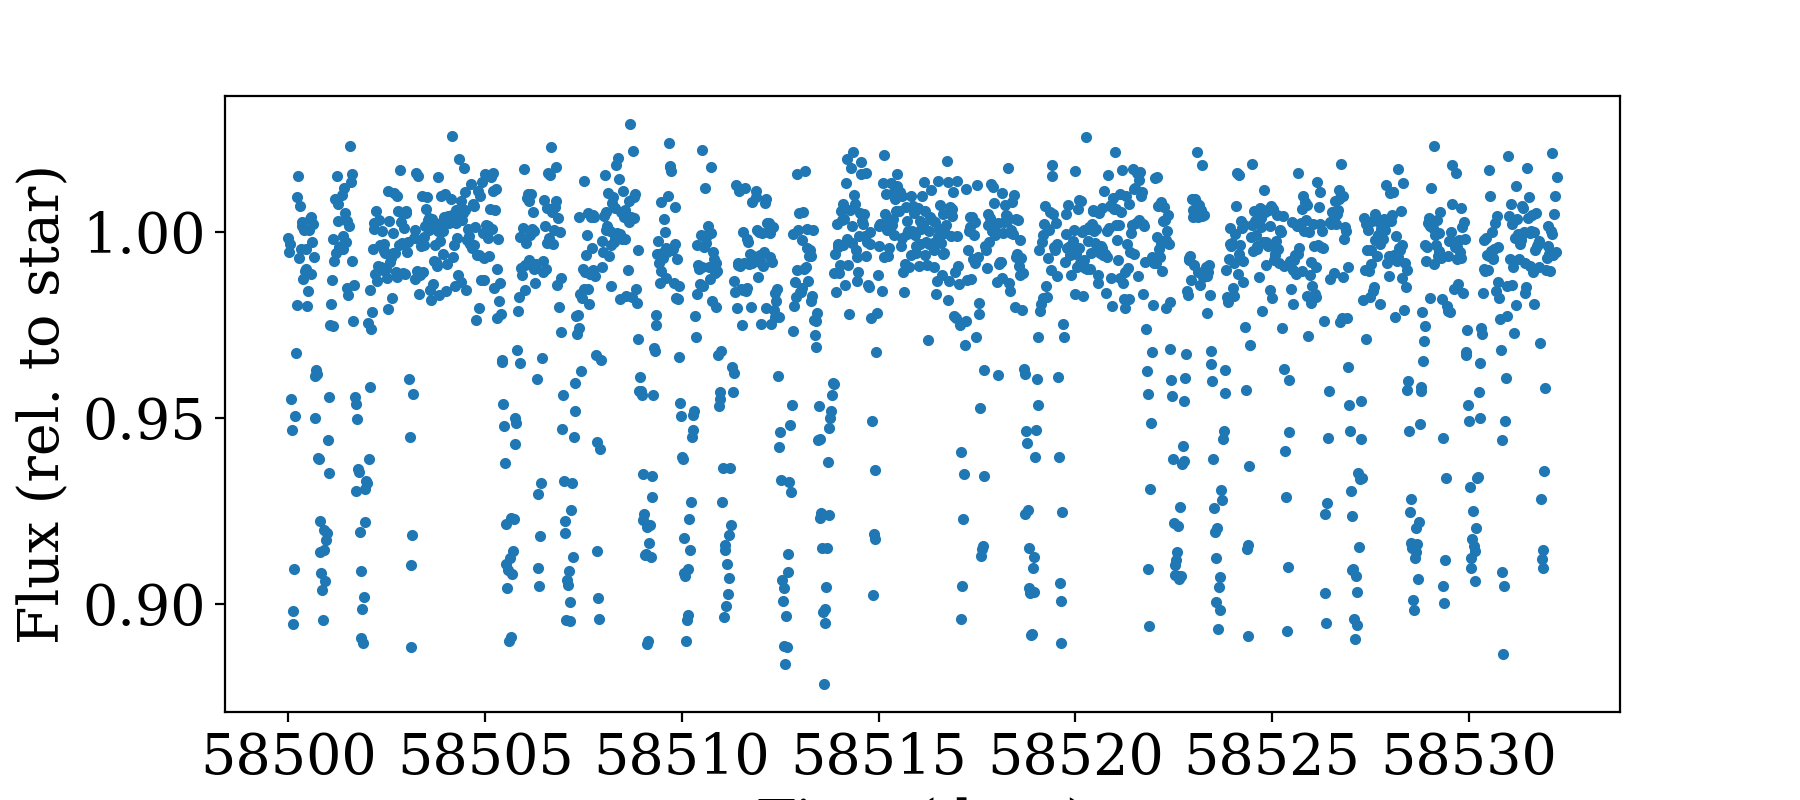

In [7]:
%matplotlib notebook
t1, lc1 = morse_lc('we come in peace', 0.5 * hr_to_day, 0.01, 58500, 21,
                   ampl_dot = ampl_dot1, ampl_hyphen = ampl_dot1, dur_dot = dot_dur1, 
                   dur_hyphen = hyphen_dur1 , dur_interletter = interletter_dur1, 
                   dur_intraletter = intraletter_dur1, dur_word_space = word_space_dur1)

plt.figure(figsize=(9, 4))
plt.scatter(t1, lc1, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (days)')
plt.ion()
plt.show()

In [ ]:
#

#### zoom the figure

<IPython.core.display.Javascript object>


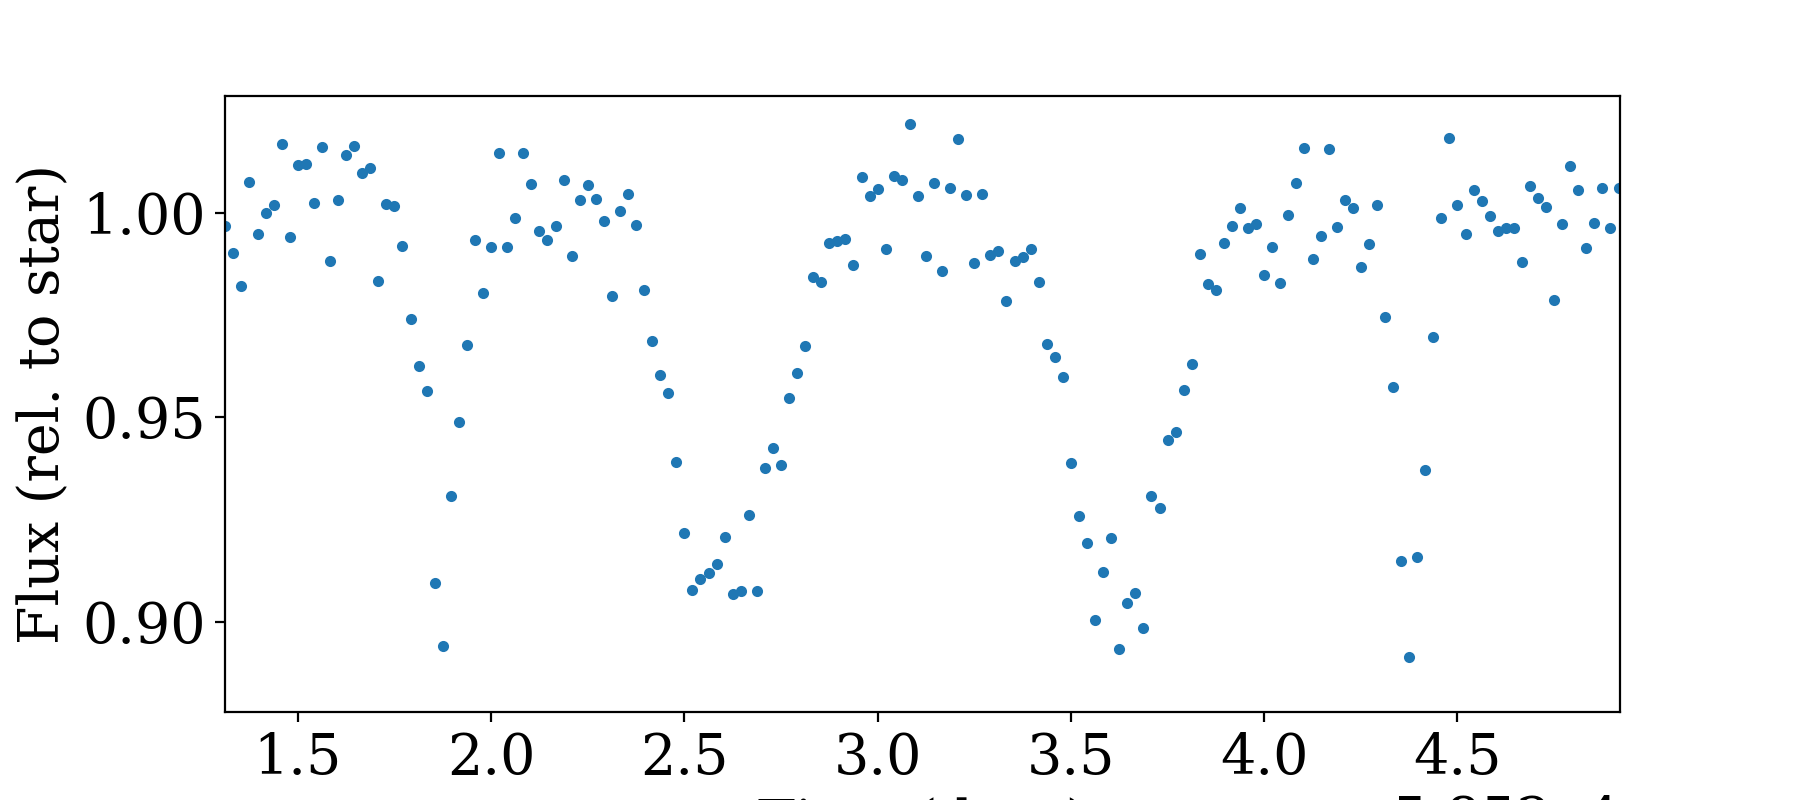

In [20]:
plt.figure(figsize=(9, 4))
plt.scatter(t1, lc1, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (days)')
plt.ion()
plt.show()

#### create the same signal but without noise, return the duration of the signal as well

In [8]:
t12, lc12, ms12, ts12 = morse_lc('live long and prosper', cadence = 0.2 * hr_to_day, obs_noise=0.01, 
                                 initial_mjd=58500, seed=21, ampl_dot = ampl_dot1, ampl_hyphen = ampl_dot1, 
                                 dur_dot = dot_dur1, dur_hyphen = hyphen_dur1 , dur_interletter = interletter_dur1, 
                                 dur_intraletter = intraletter_dur1, dur_word_space = word_space_dur1, 
                                 noise=False, time_signals=True)

In [9]:
np.array(ms12)

array(['.', '|', '-', '|', '.', '|', '.', '|', '', '.', '|', '.', '|', '',
       '.', '|', '.', '|', '.', '|', '-', '|', '', '.', '|', '', '/', '.',
       '|', '-', '|', '.', '|', '.', '|', '', '-', '|', '-', '|', '-',
       '|', '', '-', '|', '.', '|', '', '-', '|', '-', '|', '.', '|', '',
       '/', '.', '|', '-', '|', '', '-', '|', '.', '|', '', '-', '|', '.',
       '|', '.', '|', '', '/', '.', '|', '-', '|', '-', '|', '.', '|', '',
       '.', '|', '-', '|', '.', '|', '', '-', '|', '-', '|', '-', '|', '',
       '.', '|', '.', '|', '.', '|', '', '.', '|', '-', '|', '-', '|',
       '.', '|', '', '.', '|', '', '.', '|', '-', '|', '.', '|'],
      dtype='<U1')

In [10]:
ts12

array([58500.25, 58500.5 , 58501.25, 58501.5 , 58501.75, 58502.  ,
       58502.25, 58502.5 , 58503.  , 58503.25, 58503.5 , 58503.75,
       58504.  , 58504.5 , 58504.75, 58505.  , 58505.25, 58505.5 ,
       58505.75, 58506.  , 58506.75, 58507.  , 58507.5 , 58507.75,
       58508.  , 58508.5 , 58509.75, 58510.  , 58510.25, 58511.  ,
       58511.25, 58511.5 , 58511.75, 58512.  , 58512.25, 58512.75,
       58513.5 , 58513.75, 58514.5 , 58514.75, 58515.5 , 58515.75,
       58516.25, 58517.  , 58517.25, 58517.5 , 58517.75, 58518.25,
       58519.  , 58519.25, 58520.  , 58520.25, 58520.5 , 58520.75,
       58521.25, 58522.5 , 58522.75, 58523.  , 58523.75, 58524.  ,
       58524.5 , 58525.25, 58525.5 , 58525.75, 58526.  , 58526.5 ,
       58527.25, 58527.5 , 58527.75, 58528.  , 58528.25, 58528.5 ,
       58529.  , 58530.25, 58530.5 , 58530.75, 58531.5 , 58531.75,
       58532.5 , 58532.75, 58533.  , 58533.25, 58533.75, 58534.  ,
       58534.25, 58535.  , 58535.25, 58535.5 , 58535.75, 58536

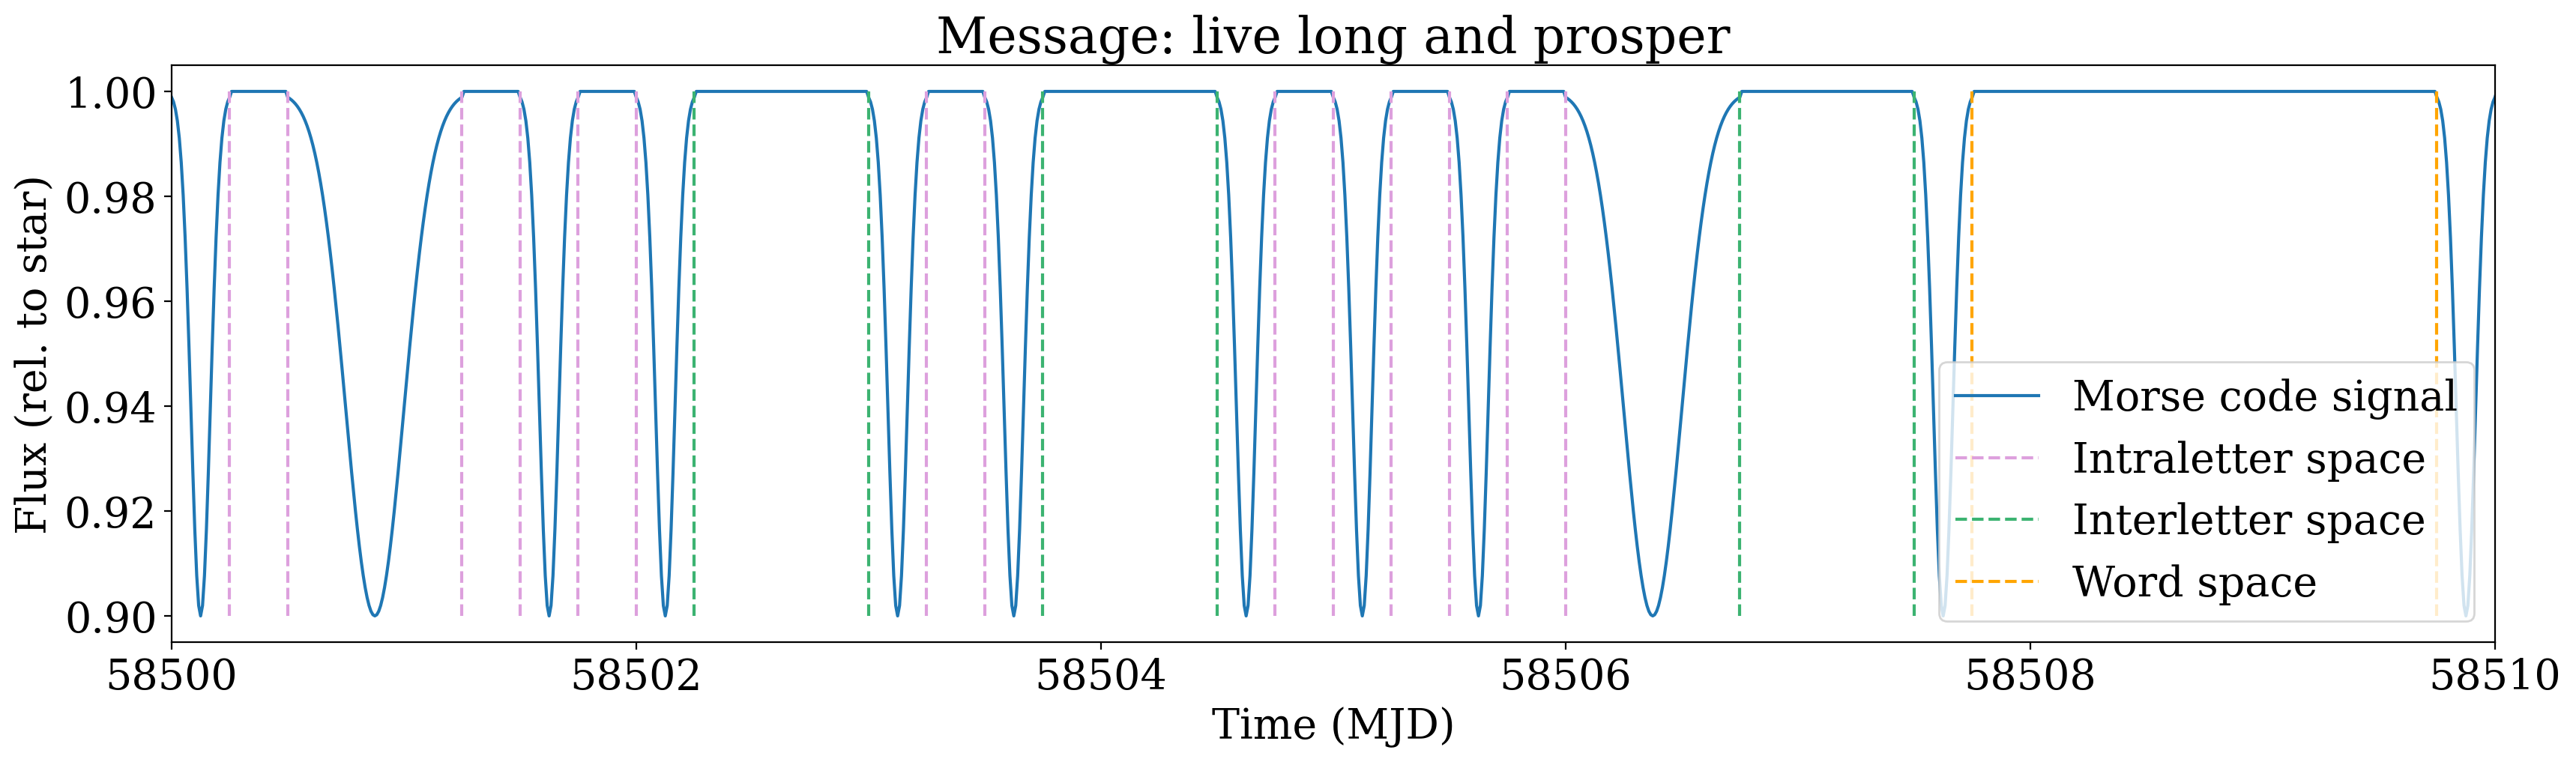

In [12]:
#%matplotlib notebook
plt.figure(figsize=(20, 5))
plt.plot(t12, lc12, label='Morse code signal')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (MJD)')
plt.title('Message: live long and prosper')
plt.vlines(np.array([58500.25, 58500.5, 58501.25, 58501.5, 58501.75, 58502., 58503.25,
                     58503.5, 58504.75, 58505., 58505.25, 58505.5, 58505.75, 58506.]), 
           0.9, 1, colors='plum', linestyles='dashed', label='Intraletter space')

plt.vlines(np.array([58502.25, 58503., 58503.75, 58504.5, 58506.75, 58507.5]), 
           0.9, 1, colors='mediumseagreen', linestyles='dashed', label='Interletter space')

plt.vlines(np.array([58507.75, 58509.75]), 
           0.9, 1, colors='orange', linestyles='dashed', label='Word space')

plt.xlim(xmin=58500, xmax=58510)
plt.legend(loc='lower right')
plt.show()

add noise

In [8]:
t13, lc13, ms13, ts13 = morse_lc('live long and prosper', cadence = 0.5 * hr_to_day, obs_noise=0.01, 
                                 initial_mjd=58500, seed=21, ampl_dot = ampl_dot1, ampl_hyphen = ampl_dot1, 
                                 dur_dot = dot_dur1, dur_hyphen = hyphen_dur1 , dur_interletter = interletter_dur1, 
                                 dur_intraletter = intraletter_dur1, dur_word_space = word_space_dur1, 
                                 noise=True, time_signals=True)

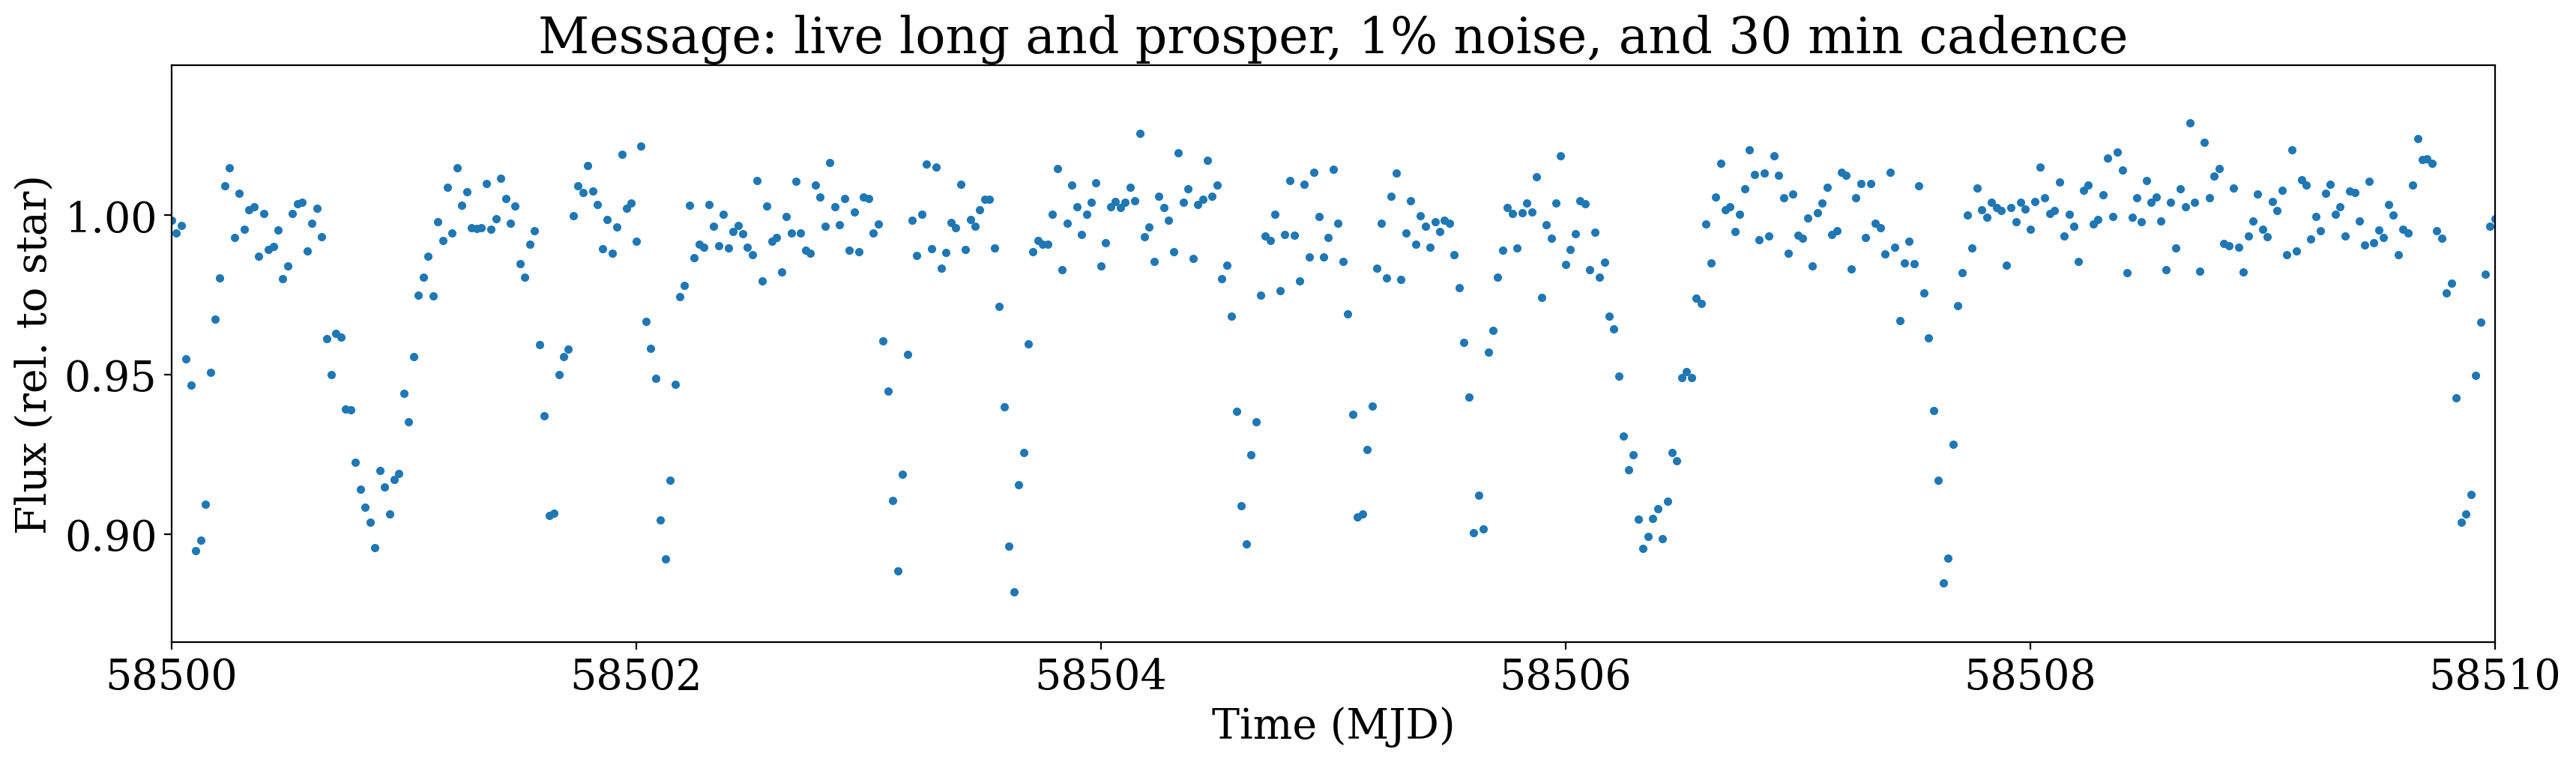

In [13]:
#%matplotlib notebook
plt.figure(figsize=(20, 5))
plt.scatter(t13, lc13, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (MJD)')
plt.xlim(xmin=58500, xmax=58510)
plt.title('Message: live long and prosper, 1% noise, and 30 min cadence')
#plt.legend()
plt.show()

#### zoom the figure

<IPython.core.display.Javascript object>


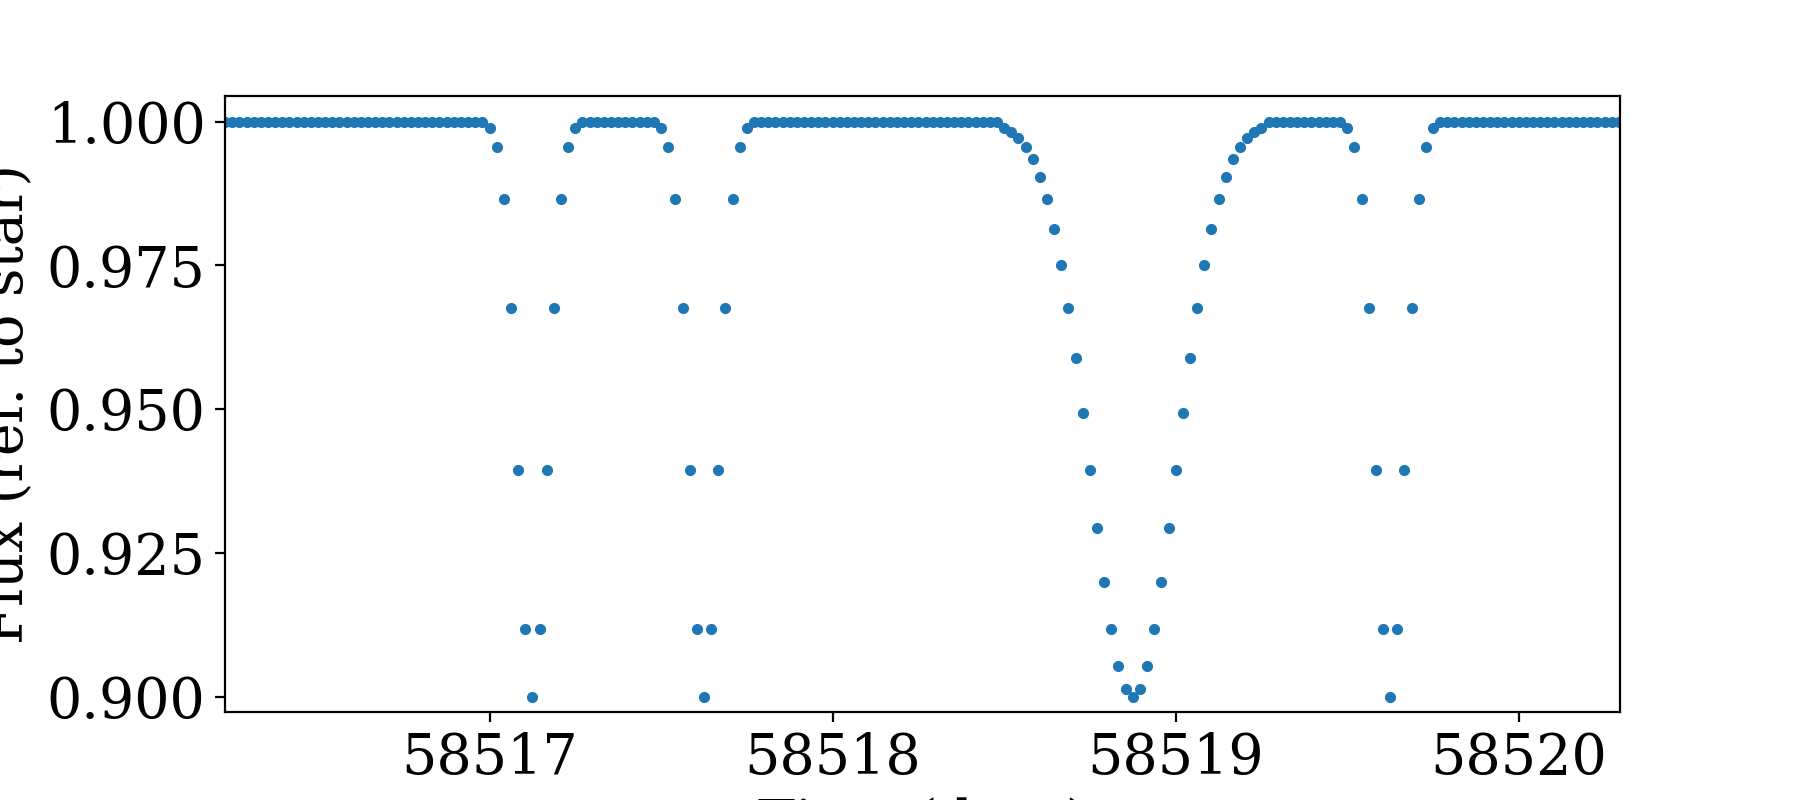

In [26]:
plt.figure(figsize=(9, 4))
plt.scatter(t12, lc12, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (days)')
plt.ion()
plt.show()

## 3.2 '.' and '-' with same different duration and amplitude

In [27]:
ampl_dot2 = 0.06
ampl_hyphen2 = 3 * ampl_dot2

<IPython.core.display.Javascript object>


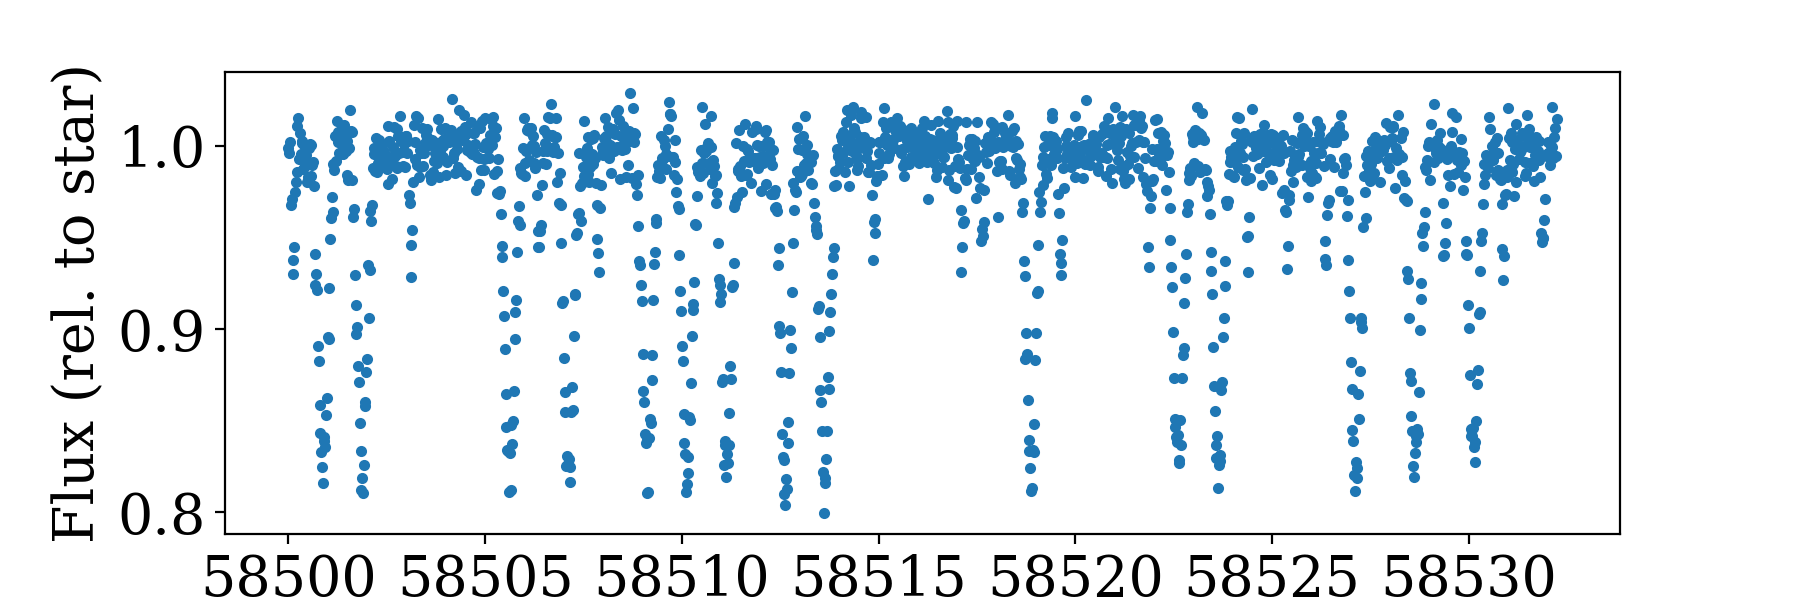

In [28]:
%matplotlib notebook
t2, lc2 = morse_lc('we come in peace', 0.5 * hr_to_day, 0.01, 58500, 21,
                   ampl_dot = ampl_dot2, ampl_hyphen = ampl_hyphen2, dur_dot = dot_dur1, 
                   dur_hyphen = hyphen_dur1 , dur_interletter = interletter_dur1, 
                   dur_intraletter = intraletter_dur1, dur_word_space = word_space_dur1)

plt.figure(figsize=(9, 3))
plt.scatter(t2, lc2, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (days)')
plt.show()

#### zoom the figure

<IPython.core.display.Javascript object>


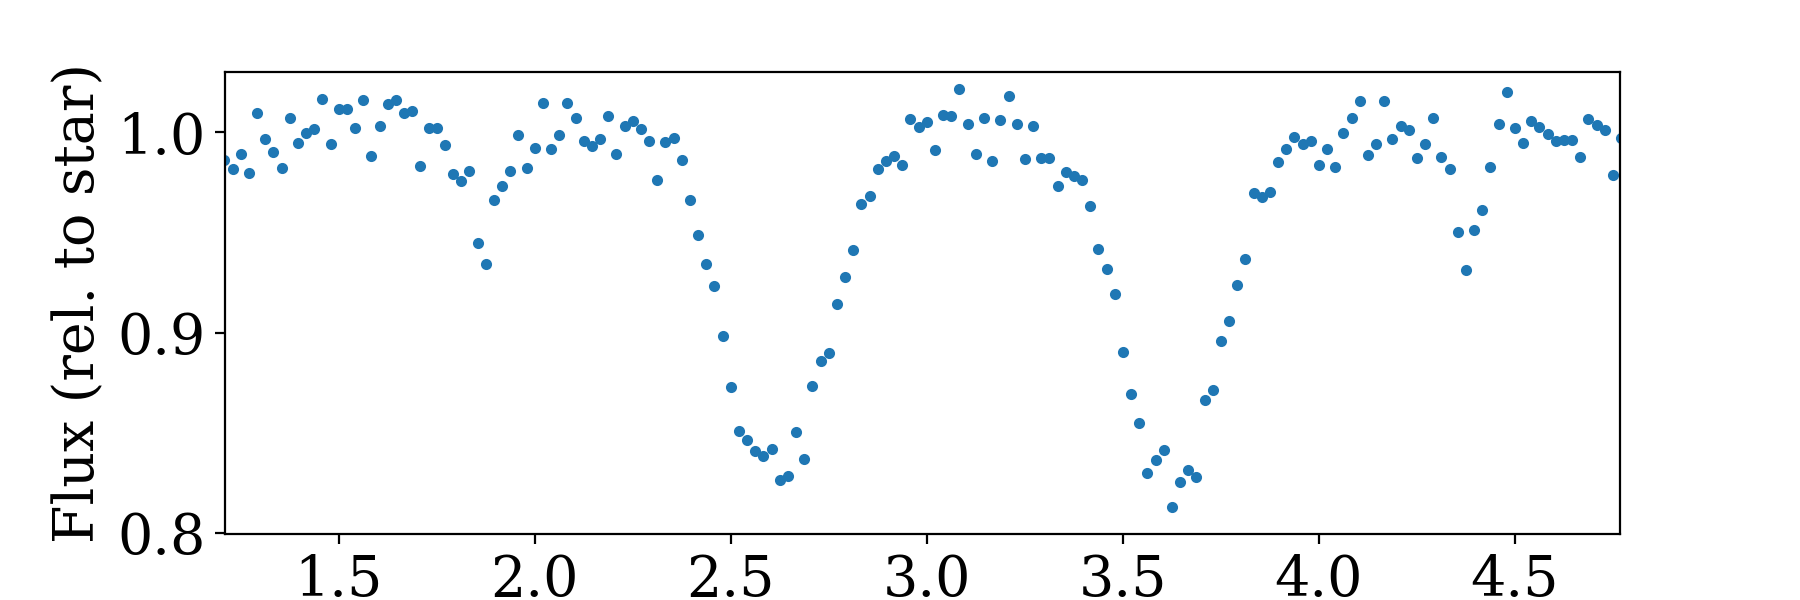

In [29]:
plt.figure(figsize=(9, 3))
plt.scatter(t2, lc2, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (days)')
plt.show()

#### create the same signal but without noise, return the duration of the signal as well

<IPython.core.display.Javascript object>


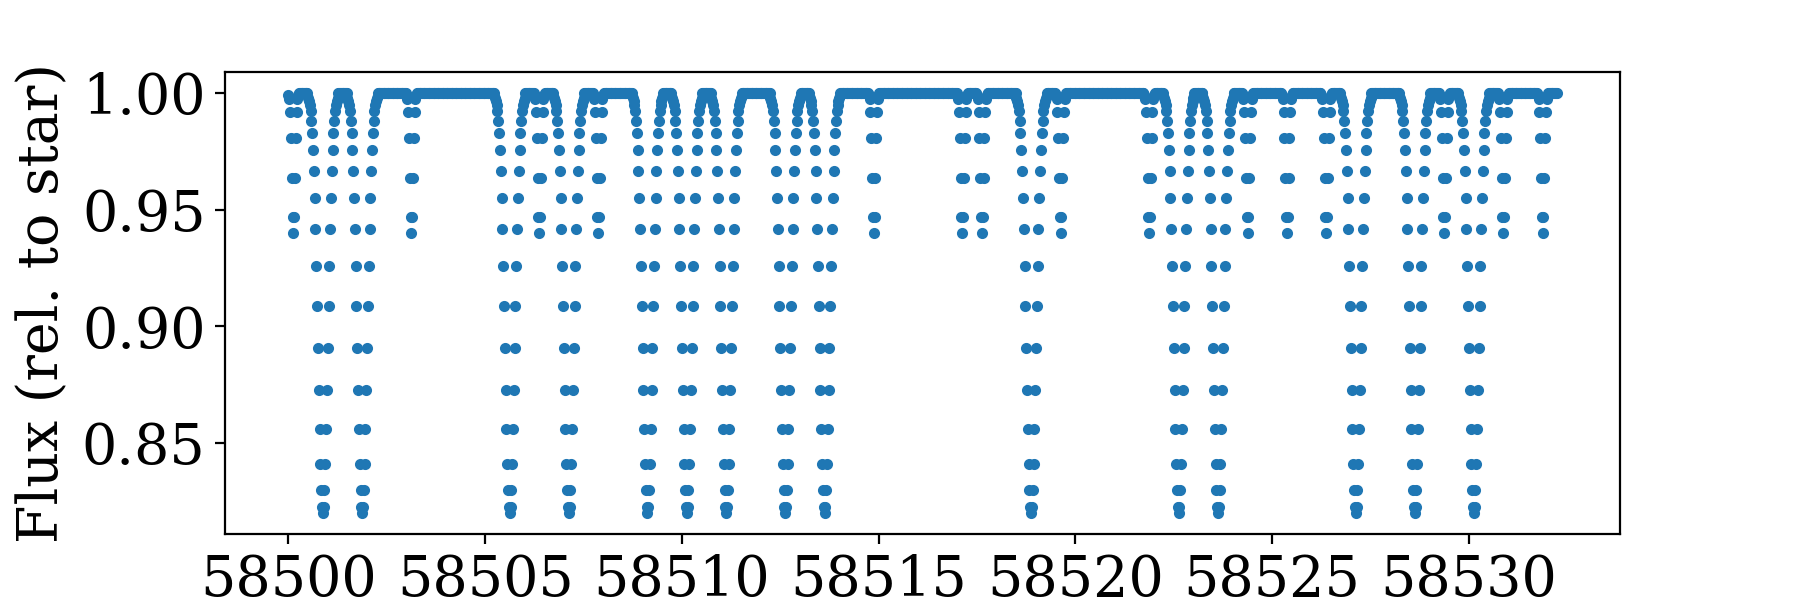

In [31]:
t22, lc22, ms22, sd22 = morse_lc('we come in peace', 0.5 * hr_to_day, 0.01, 58500, 21,
                                 ampl_dot = ampl_dot2, ampl_hyphen = ampl_hyphen2, dur_dot = dot_dur1, 
                                 dur_hyphen = hyphen_dur1 , dur_interletter = interletter_dur1, 
                                 dur_intraletter = intraletter_dur1, dur_word_space = word_space_dur1, 
                                 noise=False, dur_signals=True)

plt.figure(figsize=(9, 3))
plt.scatter(t22, lc22, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (days)')
plt.show()

#### zoom the figure

<IPython.core.display.Javascript object>


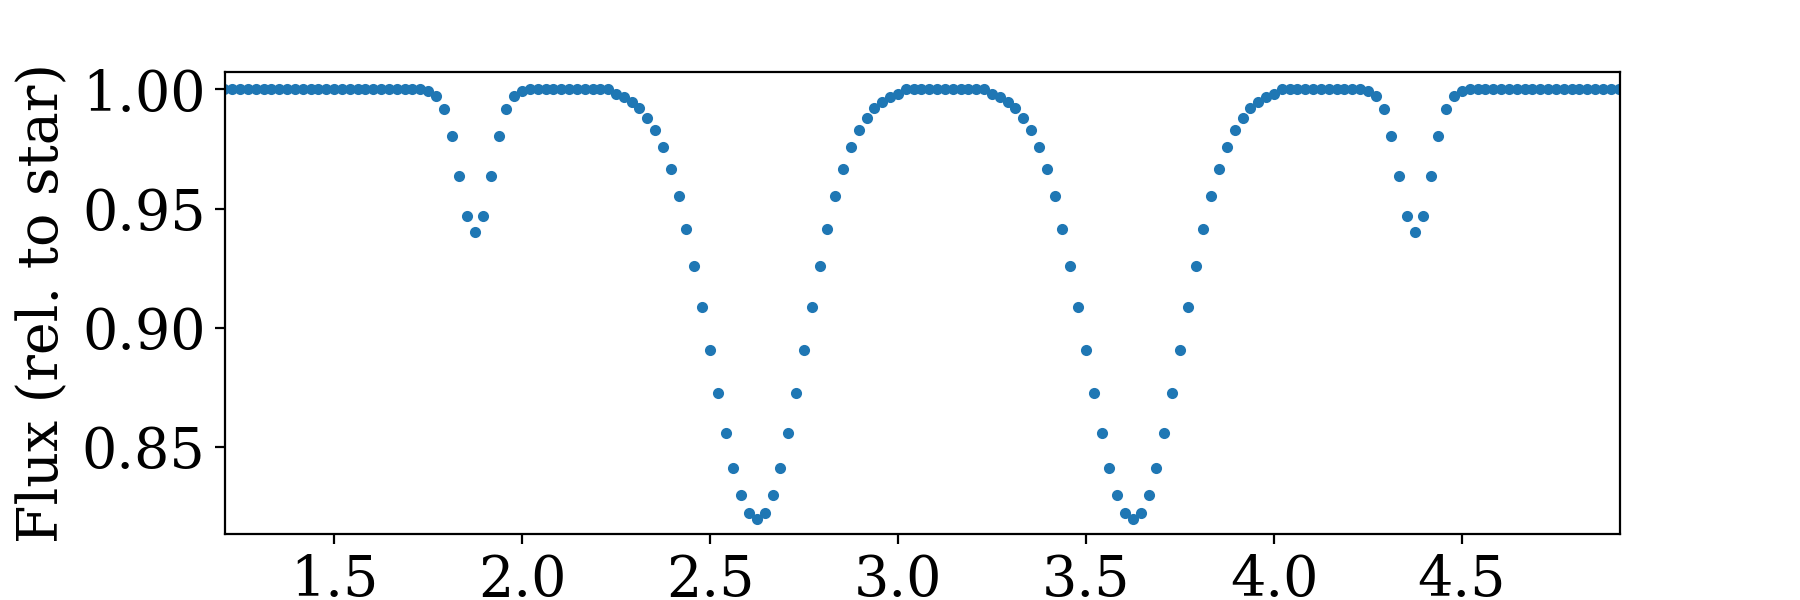

In [32]:
plt.figure(figsize=(9, 3))
plt.scatter(t22, lc22, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (days)')
plt.show()

## Create a larger message

In [13]:
l1 = 'Hello, it is me. '
l2 = 'I was wondering if after all these years you would like to meet. '
l3 = 'To go over everything. '
l4 = 'There is such a difference between us. '
l5 = 'And a million miles. '
l6 = 'Hello from the outside. '
l7 = 'I must have called a thousand times. '
l8 = 'But when I call, you never seem to be home. '

hello = l1 + l2 + l3 + l4 + l5 + l6 + l7 + l8

In [14]:
tHello1, lcHello1 = morse_lc(hello, cadence = 0.5 * hr_to_day, obs_noise=0.01, 
                             initial_mjd=58500, seed=21, ampl_dot = ampl_dot1, ampl_hyphen = ampl_dot1, 
                             dur_dot = dot_dur1, dur_hyphen = hyphen_dur1 , dur_interletter = interletter_dur1, 
                             dur_intraletter = intraletter_dur1, dur_word_space = word_space_dur1)

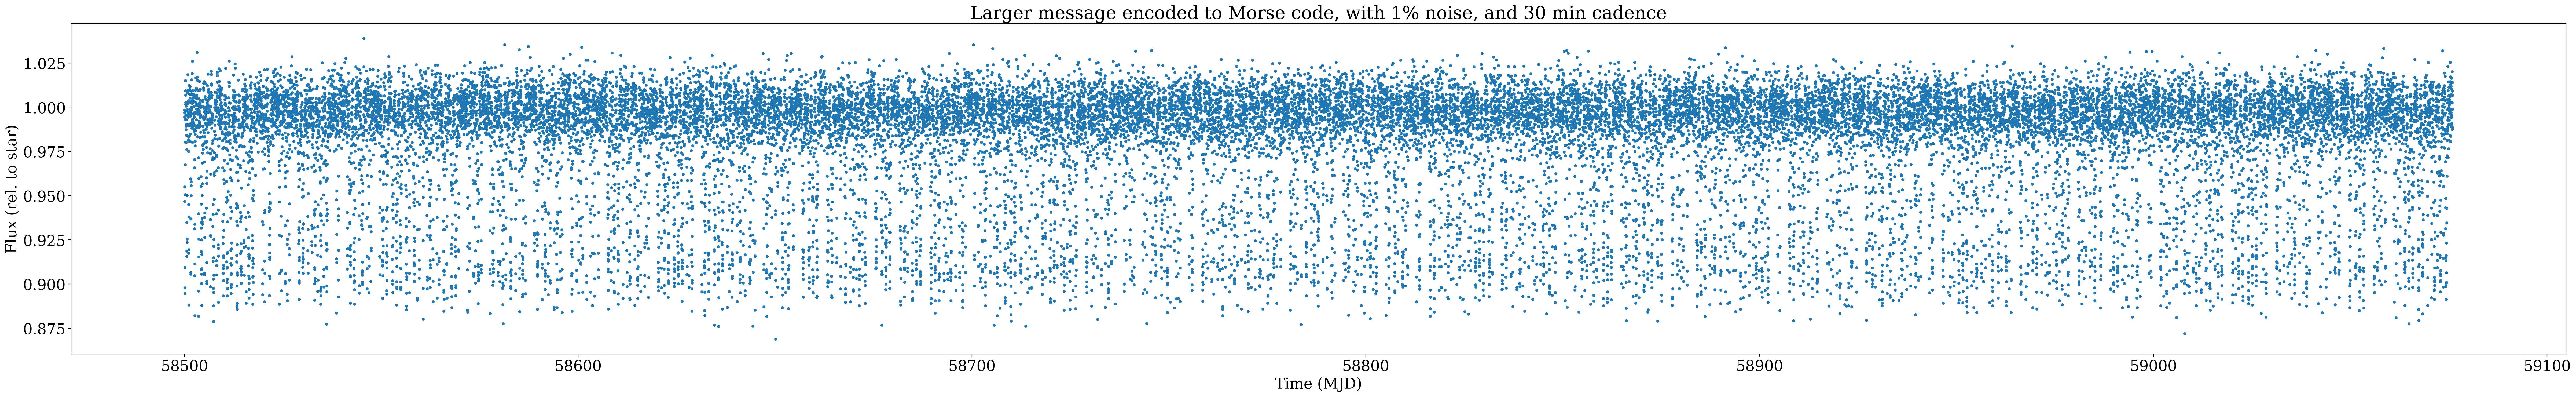

In [15]:
plt.figure(figsize=(60, 8))
plt.scatter(tHello1, lcHello1, marker='.')
plt.ylabel('Flux (rel. to star)')
plt.xlabel('Time (MJD)')
plt.title('Larger message encoded to Morse code, with 1% noise, and 30 min cadence')
plt.show()

# 4. Run a Box Least Squares periodogram on the data

In [16]:
import astropy.units as u
from astropy.timeseries import BoxLeastSquares

https://docs.astropy.org/en/stable/timeseries/bls.html

## 4.1 Use a grid of periods to create the periodogram

In [17]:
def periodogram_and_plot(t, lc, lc_error, min_period, dt_period, transit_dur, plot=True):
    
    # the maximum transit duration must be greater than the min period
    
    model = BoxLeastSquares(t * u.day, lc, dy=lc_error)
    max_period = 0.5 * (np.max(t) - np.min(t))
    periods = np.arange(min_period, max_period, dt_period) * u.day
    periodogram = model.power(periods, transit_dur)
    
    if plot:
        plt.plot(periodogram.period, periodogram.power)
        plt.xlabel('Period (days)')
        plt.ylabel('Power')
        plt.title('Periodogram')
        plt.show()
        
    else:
        return periodogram

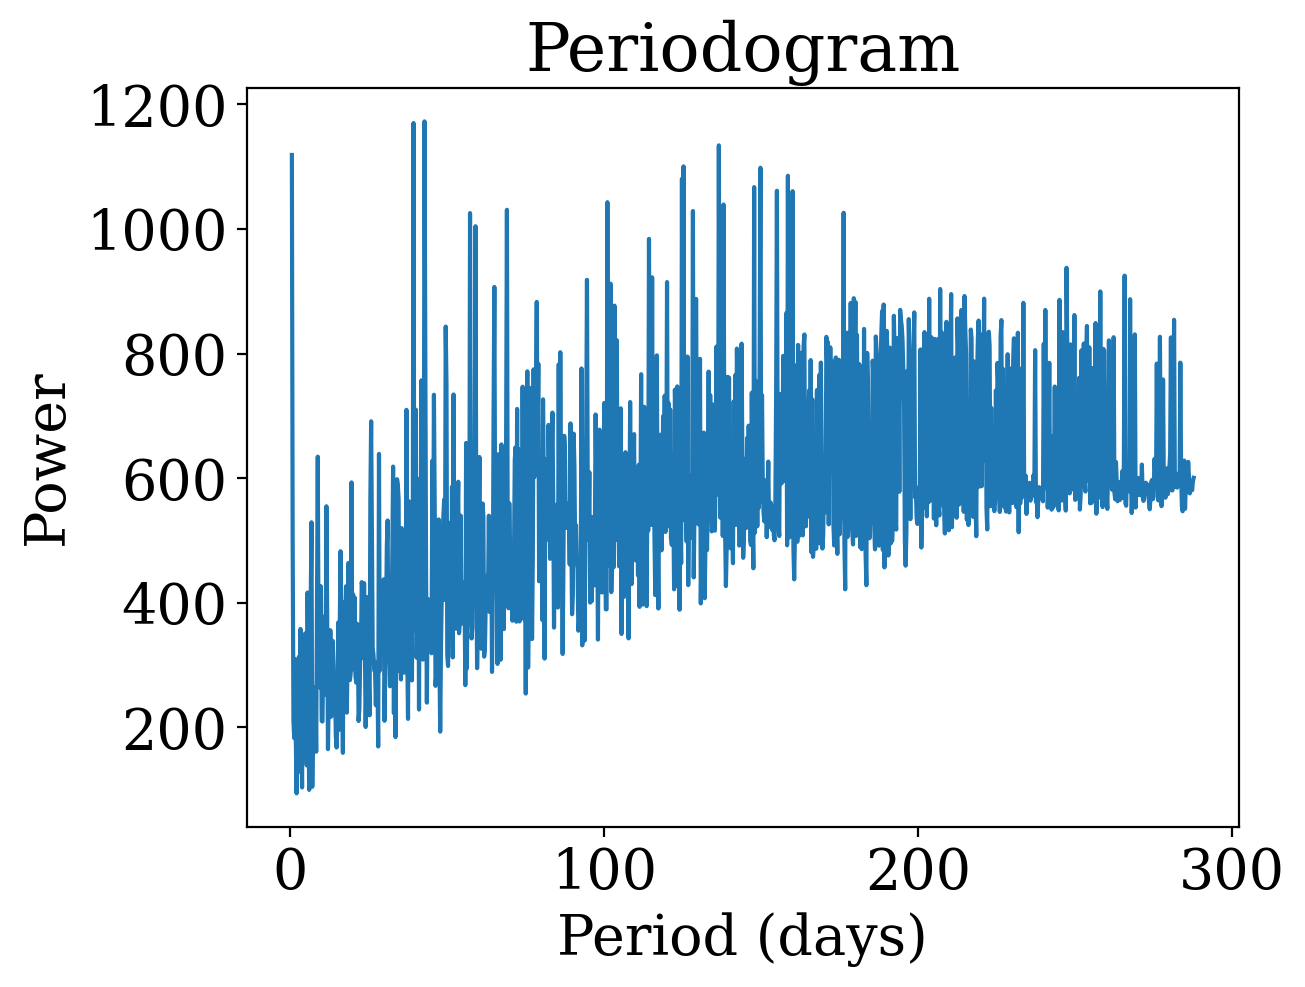

In [18]:
# can only identify if it is periodic if the period is less than half of the duration of the signal
periodogram_and_plot(tHello1, lcHello1, 0.01, 2 * dot_dur1, dot_dur1, dot_dur1)

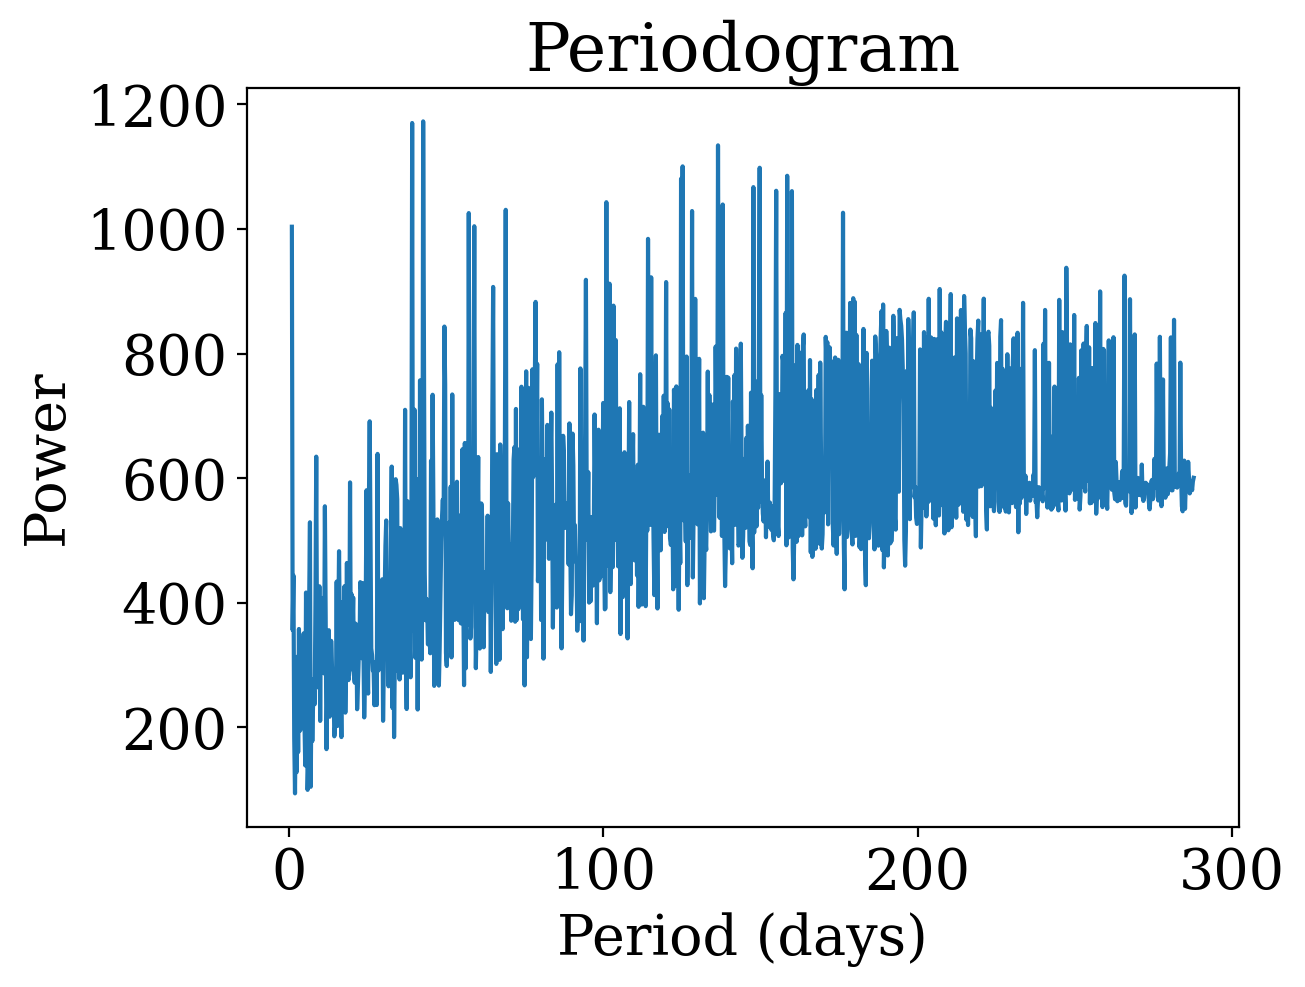

In [19]:
periodogram_and_plot(tHello1, lcHello1, 0.01, 4 * dot_dur1, dot_dur1, 
                     np.array([dot_dur1, 3 * dot_dur1]))

## 4.2 Use autopower to create the periodogram

In [20]:
model1 = BoxLeastSquares(tHello1, lcHello1, dy=0.01)
periodogram1 = model1.autopower(np.array([dot_dur1, 3 * dot_dur1]))

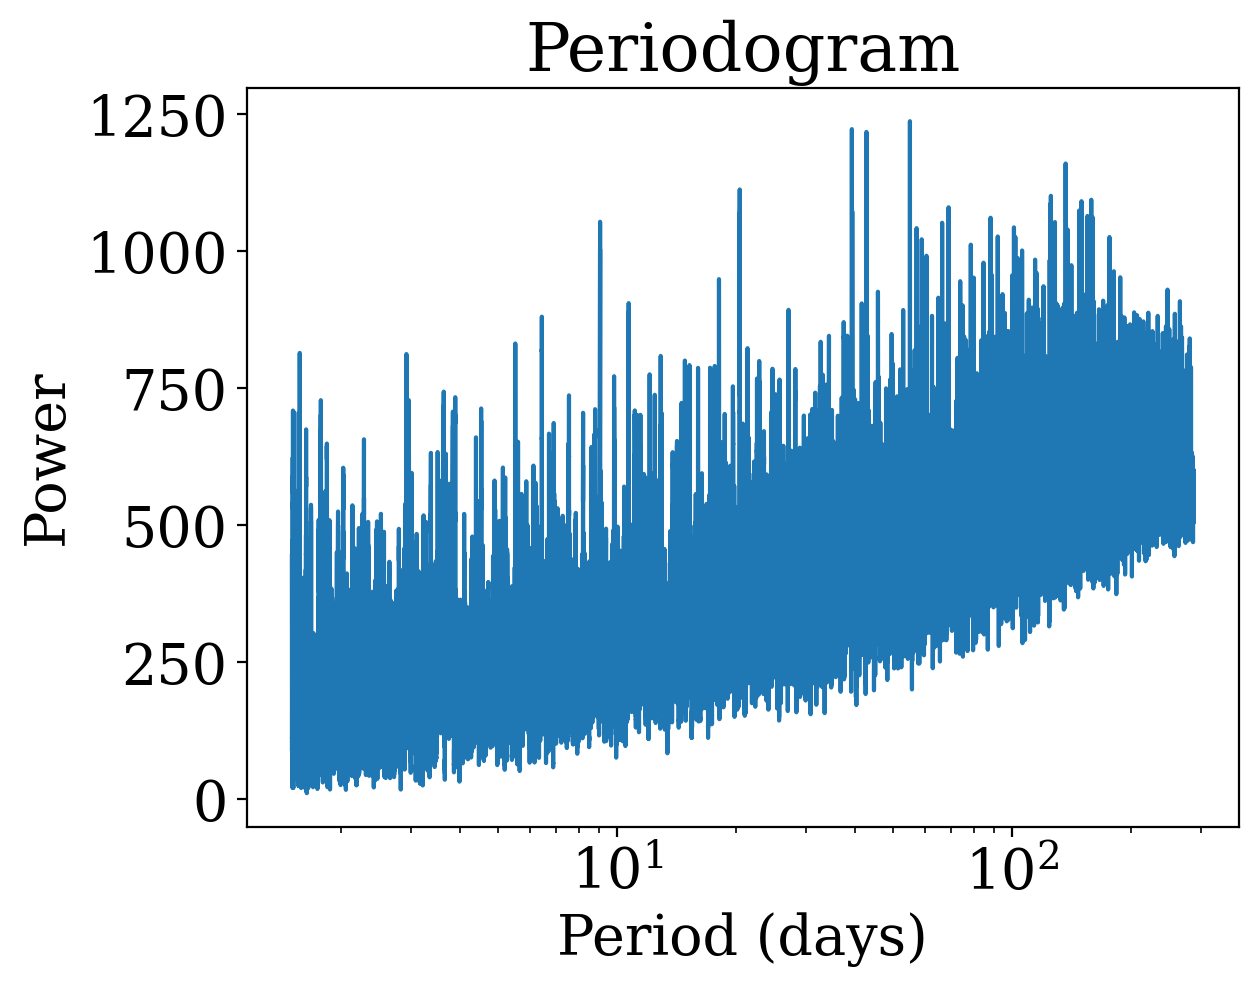

In [22]:
plt.plot(periodogram1.period, periodogram1.power)
plt.xlabel('Period (days)')
plt.ylabel('Power')
plt.title('Periodogram')
plt.xscale('log')
plt.show()